In [2]:
using PyPlot

using OrbitDynamics
using OrbitDynamics.OrbitPlotting
;

# Verifying Secular Equations

The following are equations that define the secular (non oscillating) behavior of the orbital elements under perturbations.

## J2 Gravity
With
\begin{align}
n = \sqrt{\frac{\mu}{a^3}}
\end{align}
the secular drift of RAAN is
\begin{align}
\dot{\Omega} = \frac{-3}{2} J_2 \frac{R_E^2}{(a(1-e)^2)^2} n \cos{i}
\end{align}
and the secular drift of the argument of periapsis is
\begin{align}
\dot{\omega} = \frac{3}{4} J_2 \frac{R_E^2}{(a(1-e)^2)^2} n (5\cos{i}^2 - 1).
\end{align}

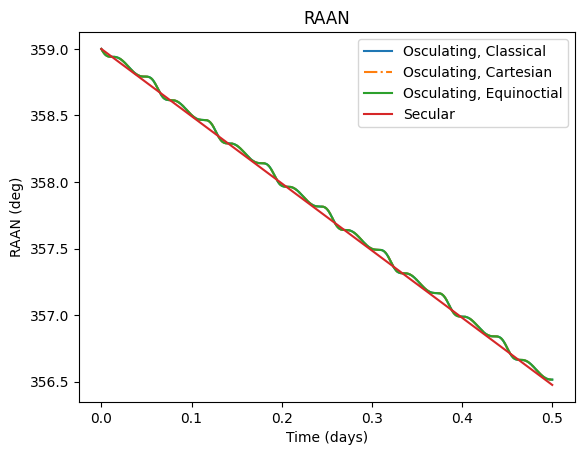

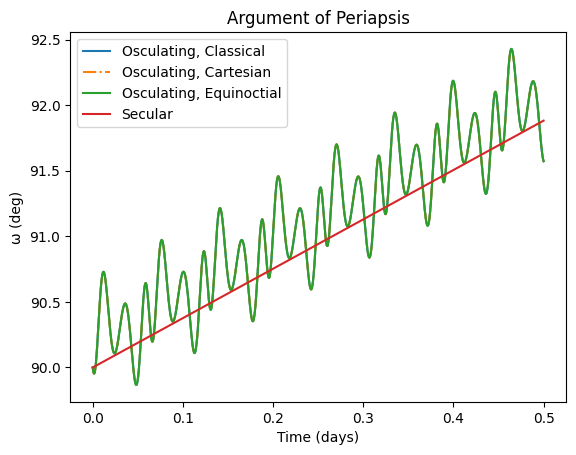

PyObject <matplotlib.legend.Legend object at 0x7f65b2683df0>

In [3]:
dp = DynamicsParameters(m_satellite_si=1.0, rho_si=0.0) # only looking at J2

sma_iss = 420e3 + dp.R_earth
e_iss = 0.1
i_iss = deg2rad(51.64)
ω_iss = deg2rad(90)
Ω_iss = deg2rad(-1) # precesses in negative direction, so make it negative
θ0_iss = deg2rad(15)

# initial state
x0 = [sma_iss, e_iss, i_iss, ω_iss, Ω_iss, θ0_iss]
x0_rv = classical_to_state_vector(x0, dp)
x0_eq = classical_to_equinoctial_elements(x0)

t_sim = 12*Int(hr)
x_rv, t_rv = solve_orbit_dynamics_ECI_state(x0_rv, dp, t_sim, 1.0)
x_cl, t = solve_orbit_dynamics_classical_elements(x0, dp, t_sim, 1.0)
x_eq, t_eq = solve_orbit_dynamics_equinoctial(x0_eq, dp, t_sim, 1.0)

x_rv_cl = reduce(hcat, [state_vector_to_classical_elements(x_rv[:,i], dp) for i=1:size(x_rv)[2]])
x_eq_cl = reduce(hcat, [equinoctial_to_classical_elements(x_eq[:,i]) for i=1:size(x_eq)[2]])


# secular raan
Omega_dot = -1.5 * dp.J2 * (dp.R_earth / (sma_iss * (1 - e_iss^2)))^2 * sqrt(dp.mu / sma_iss^3) * cos(i_iss) 

Ω_secular = Ω_iss .+ Omega_dot * t

# plot Omega
fig, ax = plt.subplots(1)
ax.plot(t ./ Int(day), rad2deg.(mod2pi.(x_cl[5,:])), label="Osculating, Classical")
ax.plot(t_rv ./ Int(day), rad2deg.(mod2pi.(x_rv_cl[5,:])), "-.", label="Osculating, Cartesian")
ax.plot(t_eq ./ Int(day), rad2deg.(mod2pi.(x_eq_cl[5,:])), label="Osculating, Equinoctial")
ax.plot(t ./ Int(day), rad2deg.(mod2pi.(Ω_secular)), label="Secular")
ax.set_title("RAAN")
ax.set_xlabel("Time (days)")
ax.set_ylabel("RAAN (deg)")
ax.legend()
fig.savefig("figures/RAAN_secular.pdf")

# secular ω
compute_secular_ω(t_i) = (3/4) * dp.J2 * (dp.R_earth / (sma_iss * (1 - e_iss^2)))^2 * sqrt(dp.mu / sma_iss^3) * (5 * cos(i_iss)^2 - 1) * t_i

ω_secular = ω_iss .+ compute_secular_ω.(t)

# plot Omega
fig, ax = plt.subplots(1)
ax.plot(t ./ Int(day), rad2deg.(mod2pi.(x_cl[4,:])), label="Osculating, Classical")
ax.plot(t_rv ./ Int(day), rad2deg.(mod2pi.(x_rv_cl[4,:])), "-.", label="Osculating, Cartesian")
ax.plot(t_eq ./ Int(day), rad2deg.(mod2pi.(x_eq_cl[4,:])), label="Osculating, Equinoctial")
ax.plot(t ./ Int(day), rad2deg.(mod2pi.(ω_secular)), label="Secular")
ax.set_title("Argument of Periapsis")
ax.set_xlabel("Time (days)")
ax.set_ylabel("ω (deg)")
ax.legend()

## Drag
For near-circular orbits, secular drift of $a$ due to atmospheric drag is
\begin{align}
\dot{a} = n \frac{1}{m} C_D A \rho a^2
\end{align}



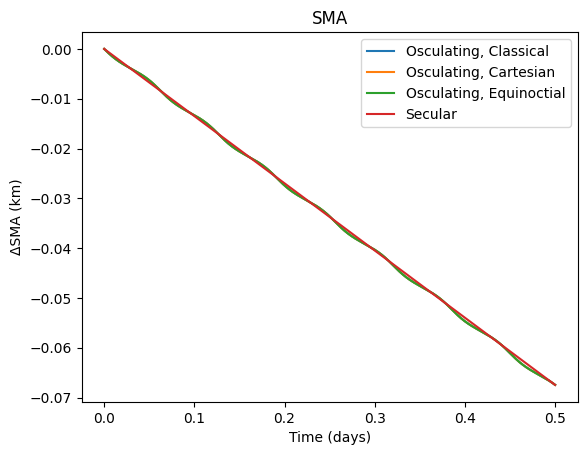

In [6]:
dp = DynamicsParameters(J2=0.0) # only looking at rho

sma_iss = 420e3 + dp.R_earth
e_iss = 0.1
i_iss = deg2rad(51.64)
ω_iss = deg2rad(90)
Ω_iss = deg2rad(-0.1) # precesses in negative direction, so make it negative
θ0_iss = deg2rad(15)

# initial state
x0 = [sma_iss, e_iss, i_iss, ω_iss, Ω_iss, θ0_iss]
x0_rv = classical_to_state_vector(x0, dp)
x0_eq = classical_to_equinoctial_elements(x0)

t_sim = 12*Int(hr)
x_rv, t_rv = solve_orbit_dynamics_ECI_state(x0_rv, dp, t_sim)
x_cl, t = solve_orbit_dynamics_classical_elements(x0, dp, t_sim)
x_eq, t_eq = solve_orbit_dynamics_equinoctial(x0_eq, dp, t_sim, 1.0)

x_rv_cl = reduce(hcat, [state_vector_to_classical_elements(x_rv[:,i], dp) for i=1:size(x_rv)[2]])
x_eq_cl = reduce(hcat, [equinoctial_to_classical_elements(x_eq[:,i]) for i=1:size(x_eq)[2]])


# secular a
compute_secular_a(t_i) = -sqrt(dp.mu / sma_iss^3) * (1/dp.m_satellite) * dp.C_D * dp.A * dp.rho * sma_iss^2 * t_i

a_secular = sma_iss .+ compute_secular_a.(t)

# plot SMA
fig, ax = plt.subplots(1)
ax.plot(t ./ Int(day), (x_cl[1,:] .- x_cl[1,1]) ./ 1e3, label="Osculating, Classical")
ax.plot(t_rv ./ Int(day), (x_rv_cl[1,:] .- x_rv_cl[1,1]) ./ 1e3, label="Osculating, Cartesian")
ax.plot(t_eq ./ Int(day), (x_eq_cl[1,:] .- x_eq_cl[1,1]) ./ 1e3, label="Osculating, Equinoctial")
ax.plot(t ./ Int(day), (a_secular .- a_secular[1]) ./ 1e3, label="Secular")
ax.set_title("SMA")
ax.set_xlabel("Time (days)")
ax.set_ylabel("ΔSMA (km)")
ax.legend()
fig.savefig("figures/SMA_secular.pdf")

In [7]:
@show x_rv_cl[1,1]
@show x_rv_cl[1,end]

x_rv_cl[1, 1] = 6.798136299999998e6
x_rv_cl[1, end] = 6.798068846523938e6


6.798068846523938e6